Imports

In [1]:
import os
import cv2
import imghdr
from tensorflow.keras.utils import image_dataset_from_directory
from keras.layers import Rescaling
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Dropout, Flatten,Activation
import pandas as pd
import shutil
import numpy as np
from pandas import DataFrame
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.applications import resnet50
from tensorflow.keras import models, layers

Kaggle environment

In [2]:
os.environ['KAGGLE_USERNAME'] = 'nileshsujan'  # Your Kaggle username
os.environ['KAGGLE_KEY'] = 'a14ec67a0281632ac749cb103ec401fb'  # Your Kaggle API key
os.environ['URN'] = '6636843'  # Your URN: submissions without a URN will not count

Download dataset from kaggle

In [3]:
!kaggle competitions download -c uos-com2028-21-22-cw


  0%|          | 0.00/181M [00:00<?, ?B/s]
  1%|1         | 2.00M/181M [00:00<00:12, 15.0MB/s]
  2%|2         | 4.00M/181M [00:00<00:10, 17.8MB/s]
  3%|3         | 6.00M/181M [00:00<00:09, 18.9MB/s]
  5%|4         | 9.00M/181M [00:00<00:08, 21.7MB/s]
  7%|6         | 12.0M/181M [00:00<00:08, 20.5MB/s]
  8%|8         | 15.0M/181M [00:00<00:08, 21.8MB/s]
 10%|9         | 18.0M/181M [00:00<00:07, 22.7MB/s]
 12%|#1        | 21.0M/181M [00:01<00:07, 22.3MB/s]
 13%|#3        | 24.0M/181M [00:01<00:07, 22.8MB/s]
 15%|#4        | 27.0M/181M [00:01<00:06, 23.2MB/s]
 17%|#6        | 30.0M/181M [00:01<00:07, 21.9MB/s]
 18%|#8        | 33.0M/181M [00:01<00:07, 20.8MB/s]
 20%|#9        | 36.0M/181M [00:01<00:07, 21.0MB/s]
 21%|##1       | 39.0M/181M [00:01<00:07, 21.1MB/s]
 23%|##3       | 42.0M/181M [00:02<00:06, 21.6MB/s]
 25%|##4       | 45.0M/181M [00:02<00:06, 21.7MB/s]
 26%|##6       | 48.0M/181M [00:02<00:06, 20.7MB/s]
 28%|##8       | 51.0M/181M [00:02<00:06, 20.3MB/s]
 29%|##9       | 53.

Check for any corrupted images just incase (corrupt images in lab7 gave me PTSD)

In [9]:
def check_images( s_dir, ext_list):
    bad_images=[]
    bad_ext=[]
    s_list = os.listdir(s_dir)
    for klass in s_list:
        klass_path=os.path.join (s_dir, klass)
        print ('processing class directory ', klass)
        if os.path.isdir(klass_path):
            file_list=os.listdir(klass_path)
            for f in file_list:               
                f_path=os.path.join (klass_path,f)
                tip = imghdr.what(f_path)
                if ext_list.count(tip) == 0:
                    bad_images.append(f_path)
                if os.path.isfile(f_path):
                    try:
                        img=cv2.imread(f_path)
                        shape=img.shape
                    except:
                        print('file ', f_path, ' is not a valid image file')
                        bad_images.append(f_path)
                else:
                    print('*** fatal error, you a sub directory ', f, ' in class directory ', klass)
        else:
            print ('*** WARNING*** you have files in ', s_dir, ' it should only contain sub directories')
    return bad_images, bad_ext

source_dir =r'images'
good_exts=['jpg'] # list of acceptable extensions
bad_file_list, bad_ext_list=check_images(source_dir, good_exts)
if len(bad_file_list) != 0:
    print('bad images')
    for i in bad_file_list:
        print(i)

processing class directory  test
file  images\test\16549.jpg  is not a valid image file
file  images\test\22231.jpg  is not a valid image file
file  images\test\25427.jpg  is not a valid image file


KeyboardInterrupt: 

Print CSV file

In [45]:
df = pd.read_csv ('images/train.csv', dtype = str)
print(df)

            Id Cell type
0       000000         3
1       000001         3
2       000002         0
3       000003         2
4       000004         0
...        ...       ...
149995  149995         7
149996  149996         7
149997  149997         3
149998  149998         7
149999  149999         6

[150000 rows x 2 columns]


Move files to use as labels

In [54]:
for index, row in df.iterrows():
    current_dest = "images/train/"+row[0]+".jpg"
    target_dest = "images/"+row[1]
    shutil.move(current_dest, target_dest) 

Move the new folders back to the train folder

In [58]:
for x in range(0,8):
    current_dest = "images/"+str(x)
    target_dest = "images/train"
    shutil.move(current_dest, target_dest) 

Error: Destination path 'images/train\0' already exists

Load dataset

In [3]:
colour_mode = 'rgb'
image_size = (28,28)
bs = 8

train_dataset = image_dataset_from_directory(
  'images/train',
  color_mode=colour_mode,
  validation_split=0.2,
  subset='training',
  seed=42,
  label_mode='categorical',
  image_size=image_size,
  batch_size=bs)

validation_dataset = image_dataset_from_directory(
  'images/train',
  color_mode=colour_mode,
  validation_split=0.2,
  subset='training',
  seed=42,
  label_mode='categorical',
  image_size=image_size,
  batch_size=bs)

test_dataset = image_dataset_from_directory(
  'images/test',
  shuffle=False,
  labels=None, 
  color_mode=colour_mode,
  image_size=image_size,
  batch_size=1)

Found 150000 files belonging to 8 classes.
Using 120000 files for training.
Found 150000 files belonging to 8 classes.
Using 120000 files for training.
Found 50000 files belonging to 1 classes.


Create model

In [32]:
model = Sequential()
model.add(Rescaling(1./255))
model.add(Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu', input_shape=(28,28,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(8, activation='softmax'))


es = [EarlyStopping(monitor='val_loss', mode='min', patience = 10),
             ModelCheckpoint(filepath='pred', monitor='val_loss', mode='min', save_best_only=True)]

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
p = model.fit(train_dataset, validation_data=validation_dataset, epochs=30, callbacks = [es])

results = model.predict(test_dataset)

Epoch 1/30
 1052/15000 [=>............................] - ETA: 3:26 - loss: 1.6687 - accuracy: 0.4217

KeyboardInterrupt: 

Graphical stuff

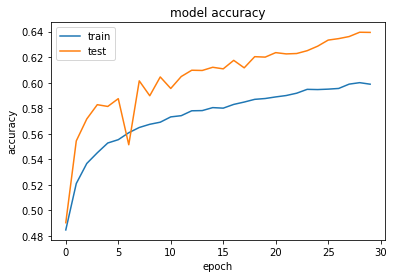

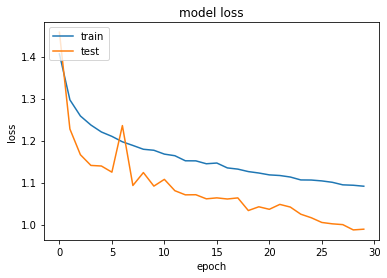

In [35]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# summarize history for accuracy
plt.plot(p.history['accuracy'])
plt.plot(p.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(p.history['loss'])
plt.plot(p.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Get predictions

In [8]:
predictions = [train_dataset.class_names[np.argmax(element)] for element in results]

Format the predictions

In [9]:
DataFrame(data={'Cell type': predictions}).to_csv('predictions.csv', index_label='Id')

Submit to Kaggle:

In [10]:
!kaggle competitions submit -m $URN -c uos-com2028-21-22-cw -f predictions.csv

Successfully submitted to COM2028 21/22 CW


  0%|          | 0.00/429k [00:00<?, ?B/s]
 30%|##9       | 128k/429k [00:00<00:00, 1.29MB/s]
100%|##########| 429k/429k [00:01<00:00, 276kB/s] 
